In [1]:
#Loading the dataset
import pandas as pd
import numpy as np
df = pd.read_csv("dataset/photos.tsv000", sep="\t", header=0)
df = df.loc[:,"photo_id":"photo_image_url":1]
df

,photo_id,photo_url,photo_image_url
0,bygTaBey1Xk,https://unsplash.com/photos/bygTaBey1Xk,https://images.unsplash.com/uploads/1413387620...
1,gXSFnk2a9V4,https://unsplash.com/photos/gXSFnk2a9V4,https://images.unsplash.com/reserve/jEs6K0y1Sb...
2,grg6-DNJuaU,https://unsplash.com/photos/grg6-DNJuaU,https://images.unsplash.com/uploads/1412192004...
3,sO42hhChB1c,https://unsplash.com/photos/sO42hhChB1c,https://images.unsplash.com/reserve/ijl3tATFRp...
4,tkk8_HakQ98,https://unsplash.com/photos/tkk8_HakQ98,https://images.unsplash.com/reserve/6vaWXsQuSW...
...,...,...,...
24995,rZQq3bdOsJU,https://unsplash.com/photos/rZQq3bdOsJU,https://images.unsplash.com/photo-159220387694...
24996,swQ3JS8e-Fs,https://unsplash.com/photos/swQ3JS8e-Fs,https://images.unsplash.com/photo-159186159766...
24997,pZroun8cH1w,https://unsplash.com/photos/pZroun8cH1w,https://images.unsplash.com/photo-159256175999...
24998,JqOvq9ypB4w,https://unsplash.com/photos/JqOvq9ypB4w,https://images.unsplash.com/photo-159191191322...


In [2]:
import torch
from transformers import CLIPProcessor, CLIPModel

#Loading the model
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')

#Loading the processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def extract_image_features(image):
    # Load the image
#     image = Image.open(image_path)
    
    # Preprocess the image using CLIP's processor
    inputs = processor(images=image, return_tensors="pt", padding=True)
    
    # Extract image features using CLIP model
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    
    # Normalize the image features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    
    return image_features

#Defining the function to create embeddings
def create_embeddings(image=None, text=None):
    text_embeddings = None
    image_embeddings = None
    
    #Processing images
    if image is not None:
        image_embeddings = extract_image_features(image)
        #image_embeddings = image_embeddings.numpy()
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
        image_embeddings = image_embeddings.numpy()
        image_embeddings = image_embeddings.squeeze(0).tolist()
    
    #Processing text:
    if text is not None:
        text_inputs = processor(text=[text], return_tensors="pt", padding=True)
        with torch.no_grad():
            text_outputs = model.get_text_features(**text_inputs)
            text_embeddings = text_outputs / text_outputs.norm(dim=-1, keepdim=True)
            text_embeddings = text_embeddings.squeeze(0).tolist()
    
    if image_embeddings is not None and text_embeddings is not None:
        combined_embeddings = np.add(image_embeddings, text_embeddings)
        combined_embeddings = [x/2 for x in combined_embeddings]
        #combined_embeddings = combined_embeddings / combined_embeddings.norm(dim=-1, keepdim=True)
        #return combined_embeddings.tolist()
        return combined_embeddings
    
    #If any one of the text or image embeddings are available
    return image_embeddings if image_embeddings is not None else text_embeddings

In [3]:
from PIL import Image
# Import the requests module for making HTTP requests
import requests
# Import tqdm for processing bar visualization
from tqdm.auto import tqdm

photo_ids = df['photo_id'][:10000]
# Filter the DataFrame to get the required columns
df = df.loc[photo_ids.index, ['photo_id', 'photo_image_url']]
# Create a session to make HTTP requests
session = requests.Session()

# Define the Python function to download and get embeddings
def process_image(url):
    try:
        # Make a GET request to download the image
        response = session.get(url, stream=True)
        response.raise_for_status()
        image = Image.open(response.raw)
        # Get the embeddings and return
        return create_embeddings(image)
    except requests.RequestException:
        return None
# construct a URL to download the image with a smaller size
df['photo_image_url'] = df['photo_image_url'].apply(lambda x: x + "?q=75&fm=jpg&w=200&fit=max")
# Pass the images one by one to the 'process_image' and save the embeddings to the newly created column 'photo_embed'
df['photo_embed'] = [process_image(url) for url in tqdm(df['photo_image_url'], total=len(df))]

# Remove rows where image processing failed
df.dropna(subset=['photo_embed'], inplace=True)
# Reset the index and rename the 'id' column to 'index'
df = df[df['photo_id'].isin(photo_ids)].reset_index().rename(columns={'index': 'id'})

# Close the session
session.close()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [4]:
df.to_csv("out.csv", index=False)

In [5]:
df

,id,photo_id,photo_image_url,photo_embed
0,0,bygTaBey1Xk,https://images.unsplash.com/uploads/1413387620...,"[-0.002798730041831732, -0.011908511631190777,..."
1,1,gXSFnk2a9V4,https://images.unsplash.com/reserve/jEs6K0y1Sb...,"[0.002107632579281926, 0.007745462469756603, -..."
2,2,grg6-DNJuaU,https://images.unsplash.com/uploads/1412192004...,"[0.01119258999824524, 0.025637807324528694, 0...."
3,3,sO42hhChB1c,https://images.unsplash.com/reserve/ijl3tATFRp...,"[-0.0005779609200544655, 0.009897828102111816,..."
4,4,tkk8_HakQ98,https://images.unsplash.com/reserve/6vaWXsQuSW...,"[-0.04457324370741844, -0.023003479465842247, ..."
...,...,...,...,...
9994,9995,jUsuh8ZZyNo,https://images.unsplash.com/photo-159198138736...,"[0.006990955211222172, 0.00563522893935442, 0...."
9995,9996,6v6ZfsD7TkA,https://images.unsplash.com/photo-159160409308...,"[0.009876025840640068, 0.04049515351653099, -0..."
9996,9997,TK1z7nRT6aE,https://images.unsplash.com/photo-159161021725...,"[0.025314582511782646, 0.016122421249747276, 0..."
9997,9998,SmK_abMCC8Q,https://images.unsplash.com/photo-159558696463...,"[0.04403617978096008, -0.011088347993791103, 0..."


In [9]:
import clickhouse_connect

client = clickhouse_connect.get_client(
    host='msc-42fce9e7.us-east-1.aws.myscale.com',
    port=443,
    username='guna_org_default',
    password='passwd_anHjEhwoJDJAEm'
)

In [10]:
#Dropping table if it exists
client.command("DROP TABLE IF EXISTS default.photos")

#Creating the table
client.command("""
        CREATE TABLE default.photos
        (
            id UInt64,
            photo_id String,
            photo_image_url String,
            photo_embed Array(Float32),
            CONSTRAINT vector_len CHECK length(photo_embed) = 512
        )
        ORDER BY id
        """)

['0', 'chi-msc-42fce9e7-msc-42fce9e7-0-0', 'OK', '0', '0']

In [11]:
# upload data from datasets
client.insert("default.photos", df.to_records(index=False).tolist(),
              column_names=df.columns.tolist())

# check count of inserted data
print(f"photos count: {client.command('SELECT count(*) FROM default.photos')}")

# create vector index with cosine
client.command("""
ALTER TABLE default.photos 
ADD VECTOR INDEX photo_embed_index photo_embed
TYPE MSTG
('metric_type=Cosine')
""")

# check the status of the vector index, make sure vector index is ready with 'Built' status
get_index_status="SELECT status FROM system.vector_indices WHERE name='photo_embed_index'"
print(f"index build status: {client.command(get_index_status)}")

photos count: 9999
index build status: InProgress


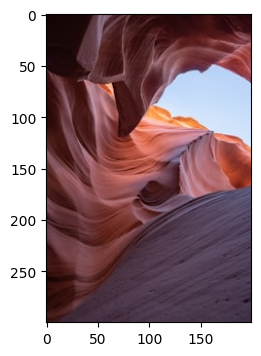

In [12]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# download image with its url
def download(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))
def show_image(url, title=None):
    img = download(url)
    fig = plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.show()
random_image = client.query("SELECT * FROM default.photos ORDER BY rand() LIMIT 1")
target_image_url = random_image.first_item["photo_image_url"]
show_image(target_image_url)

In [26]:
image_url="https://images.unsplash.com/photo-1701443478334-c1a4bfda91ff?q=80&w=1936&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
query_text="a man walking on a beach"

#Using a link to the image
session = requests.session()
response = session.get(image_url, stream=True)
response.raise_for_status()
image = Image.open(response.raw)

#Using a image file
#image = Image.open("beach.jpg")

embeddings=create_embeddings(image,query_text)

# session.close()

Loading candidate images...


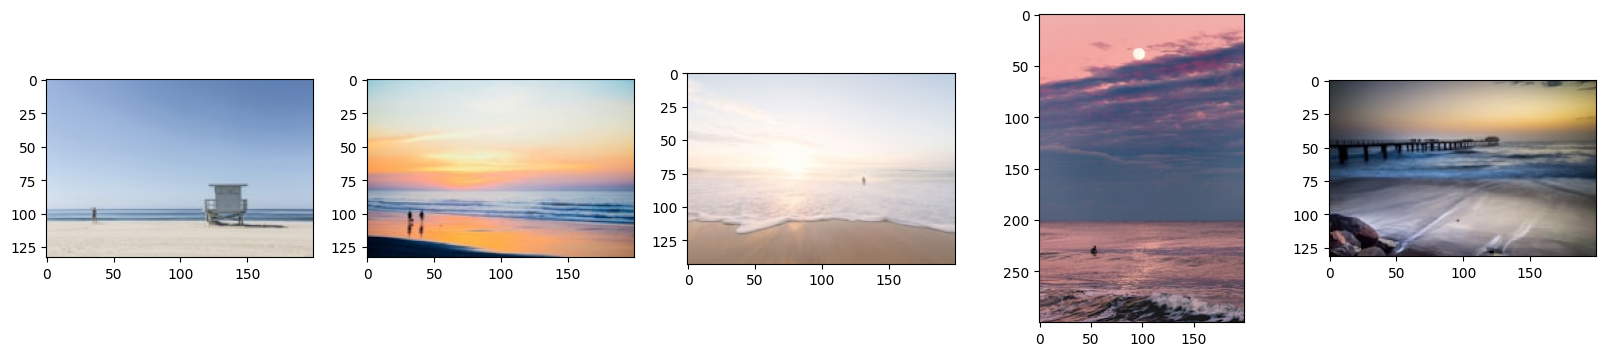

In [30]:
top_k = 5
# Query to get the relevant results from the database
results = client.query(f"""
SELECT photo_id, photo_image_url, distance(photo_embed, {embeddings}) as dist
FROM default.photos
ORDER BY dist ASC
LIMIT {top_k}
""")

# Download the relevant images
images_url = []
for r in results.named_results():
    # construct a URL to download an image with a smaller size by modifying the image URL
    url = r['photo_image_url'] + "?q=75&fm=jpg&w=200&fit=max"
    images_url.append(download(url))

# display the images
print("Loading candidate images...")
for row in range(int(top_k / 5)):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, img in enumerate(images_url[row * 5:row * 5 + 5]):
        axs[i % 5].imshow(img)
    plt.show()